In [1]:
def run_dnn(df_train_encoded, df_test_encoded):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras.optimizers import Adam
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import f1_score, confusion_matrix
    import numpy as np
    import seaborn as sns
    import tensorflow as tf
    from keras.callbacks import EarlyStopping

    # Import necessary libraries
    import matplotlib.pyplot as plt

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Ensure that 'income' is the last column for convenience
    df_train_encoded = df_train_encoded.copy()
    df_test_encoded = df_test_encoded.copy()

    # Extract features and target from df_train_encoded and df_test_encoded
    X_train = df_train_encoded.drop(columns=['income']).values
    y_train = df_train_encoded['income'].values
    X_test = df_test_encoded.drop(columns=['income']).values
    y_test = df_test_encoded['income'].values

    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the DNN model
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compute class weights to handle class imbalance
    def compute_class_weights(y):
        classes, counts = np.unique(y, return_counts=True)
        total_samples = len(y)
        num_classes = len(classes)
        class_weights = {cls: total_samples / (num_classes * count) for cls, count in zip(classes, counts)}
        return class_weights

    # Compute weights for training labels
    class_weight_dict = compute_class_weights(y_train)
    print("Computed Class Weights:", class_weight_dict)

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=256,
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    results = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", results[0])
    print("Test Accuracy:", results[1])
    print("Test Precision:", results[2])
    print("Test Recall:", results[3])

    # Predict on test data
    preds_test = model.predict(X_test)
    preds_test_binary = np.round(preds_test)

    # Compute F1 Score
    f1_test = f1_score(y_test, preds_test_binary)
    print("Test F1 Score:", f1_test)

    # Predict on training data
    preds_train = model.predict(X_train)
    preds_train_binary = np.round(preds_train)

    # Compute F1 Score on training data
    f1_train = f1_score(y_train, preds_train_binary)
    print("Train F1 Score:", f1_train)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, preds_train_binary)
    cm_test = confusion_matrix(y_test, preds_test_binary)

    # Plot confusion matrices
    plt.figure(figsize=(10, 5))

    # Confusion Matrix for Training Data
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Training Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Confusion Matrix for Test Data
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Test Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()


    # Compute F1 score for training and validation sets per epoch
    precision = history.history['Precision']
    recall = history.history['Recall']
    f1_score = 2 * (np.array(precision) * np.array(recall)) / (np.array(precision) + np.array(recall) + 1e-8)

    precision_val = history.history['val_Precision']
    recall_val = history.history['val_Recall']
    f1_score_val = 2 * (np.array(precision_val) * np.array(recall_val)) / (np.array(precision_val) + np.array(recall_val) + 1e-8)


    # Plot training & validation F1 score values
    plt.figure(figsize=(12, 4))

    # Plot training & validation F1 Score
    plt.subplot(1, 2, 1)
    plt.plot(f1_score)
    plt.plot(f1_score_val)
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation Loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

## load one hot

In [2]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("D:\\SummerResearch\data\\adult\onehot_adult_train.csv")
df_test = pd.read_csv("D:\\SummerResearch\data\\adult\onehot_adult_test.csv")

print(df_train.shape)
print(df_test.shape)
print("before adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))
# Add missing columns to df_test
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0

# Ensure the columns are in the same order
df_test = df_test[df_train.columns]


print("after adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))


# Sort columns of train and test dataframes alphabetically
df_train = df_train.reindex(sorted(df_train.columns), axis=1)
df_test = df_test.reindex(sorted(df_test.columns), axis=1)

print("Columns sorted alphabetically")
for i in range(len(df_train.columns)):
    if df_train.columns[i] != df_test.columns[i]:
        print("column difference")
        print(df_train.columns[i], df_test.columns[i])

df_train_encoded = df_train
df_test_encoded = df_test

(38095, 109)
(9526, 109)
before adding
train - test set()
test - train set()
after adding
train - test set()
test - train set()
Columns sorted alphabetically


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Computed Class Weights: {0: 0.6599279354190486, 1: 2.0632040727902945}
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - Precision: 0.4327 - Recall: 0.7215 - accuracy: 0.7063 - loss: 0.5527 - val_Precision: 0.5426 - val_Recall: 0.8441 - val_accuracy: 0.7897 - val_loss: 0.4056
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - Precision: 0.5393 - Recall: 0.8580 - accuracy: 0.7889 - loss: 0.4157 - val_Precision: 0.5495 - val_Recall: 0.8458 - val_accuracy: 0.7946 - val_loss: 0.3893
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Precision: 0.5494 - Recall: 0.8687 - accuracy: 0.7964 - loss: 0.3955 - val_Precision: 0.5575 - val_Recall: 0.8484 - val_accuracy: 0.8000 - val_loss: 0.3883
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Precision: 0.5573 - Recall: 0.8729 - accuracy: 0.8020 - loss: 0.3846 - val_Precision: 0.5661 - val_Recall: 0.8359 - val_accuracy: 0.8050 - val_loss: 0.3807
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - Precision: 0.5617 - Recal

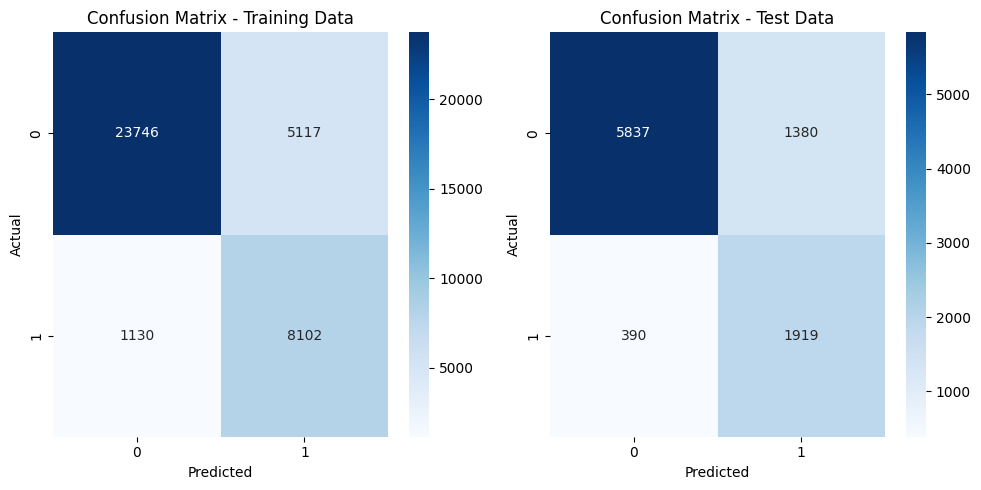

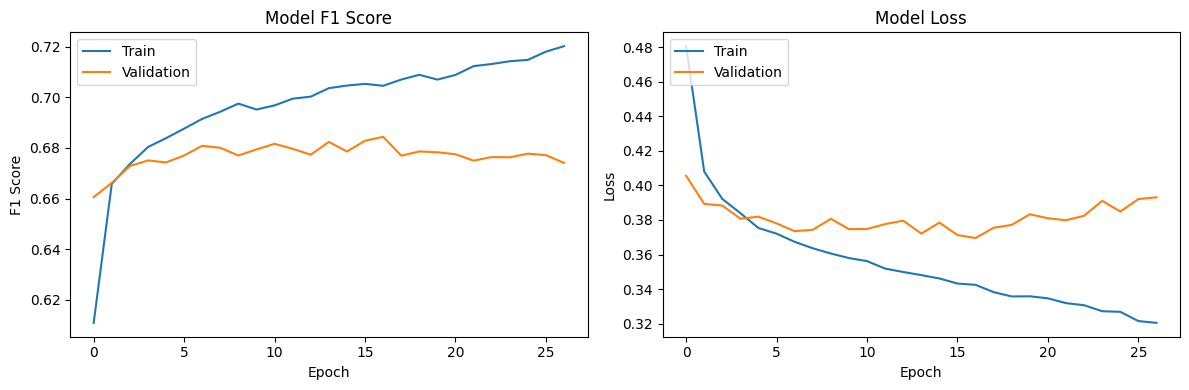

In [3]:
run_dnn(df_train_encoded, df_test_encoded)

## load pre one hot

In [6]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def prepend_col_name(df, columns):
    for col in columns:
        # print(type(col), col)
        df[col] = df[col].apply(lambda x: f"{col}_{x}")
    return df

def onehot(xtrain, xtest, categorical_columns, verbose=False):
  # copy so that the original data is not modified. 
  # if original data is modified, the rows values in train.csv and test.csv will have prepend column names
  xtrain_copy = xtrain.copy()
  xtest_copy = xtest.copy()

  # Prepend column names to train and test
  xtrain_copy = prepend_col_name(xtrain_copy, categorical_columns)
  xtest_copy = prepend_col_name(xtest_copy, categorical_columns)

  # Automatically determine the numerical columns
  numerical_cols = list(set(xtrain.columns) - set(categorical_columns))
  if verbose:
    print("xtrain shape: ", xtrain.shape)
    print("xtest shape: ", xtest.shape)
    print("Numerical columns: ", numerical_cols)

  # Prepare train_prep and test_prep
  xtrain_prep = xtrain[numerical_cols]
  xtest_prep = xtest[numerical_cols]

  # xtrain_prep.to_csv("xtrain_prep_ori.csv")

    # One-Hot Encoding with modified categorical values
  for col in categorical_columns:

      # One-Hot Encoding for xtrain_copy
      train_ohe = OneHotEncoder()
      train_ohe.set_output(transform="default") # Disable the pandas output to return an array because Pandas output does not support sparse data
      xtrain_onehot = train_ohe.fit_transform(xtrain_copy[col].values.reshape(-1,1))
      xtrain_onehot = xtrain_onehot.toarray()
      xtrain_onehot = pd.DataFrame(xtrain_onehot, columns = xtrain_copy[col].unique())

      xtrain_prep = pd.concat([xtrain_prep, xtrain_onehot], axis=1) # when dropping missing values, index won't be continuous, so concat (xtrain_prep, xtrain_onehot, axis=1) will not match

      # One-Hot Encoding for xtest_copy
      test_ohe = OneHotEncoder()
      test_ohe.set_output(transform="default") # Disable the pandas output to return an array because Pandas output does not support sparse data
      xtest_onehot = test_ohe.fit_transform(xtest_copy[col].values.reshape(-1,1))
      xtest_onehot = xtest_onehot.toarray()
      xtest_onehot = pd.DataFrame(xtest_onehot, columns = xtest_copy[col].unique())
      xtest_onehot = xtest_onehot.set_index(xtest_copy.index)
      xtest_prep = pd.concat([xtest_prep, xtest_onehot], axis=1)

      # Check differences between xtrain_copy and xtest_copy
      dif1 = set(xtest_copy[col].unique()) - set(xtrain_copy[col].unique())
      if dif1 != set():
        # safeguard 
        # make sure that the categorical values in xtest_copy are the same as in xtrain_copy
        error_message = f"""
        Differences found between xtest and xtrain in column: "{col}"
        Number of unique values in test (test - train): {len(dif1)}
        Unique values: {dif1}
        """
        raise TestTrainDiffError(error_message)

      if verbose:
        print(f"Differences between xtest and xtrain in column: {col}")
        print(len(dif1), dif1)

        
  return xtrain_prep, xtest_prep


In [12]:
train_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_train.csv")
test_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_test.csv")

categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']                    

train_df_encoded, test_df_encoded = onehot(train_df, test_df, categorical_vars, verbose=True)



df_train = train_df_encoded
df_test = test_df_encoded

print(df_train.shape)
print(df_test.shape)
print("before adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))
# Add missing columns to df_test
missing_cols = set(df_train.columns) - set(df_test.columns)
for col in missing_cols:
    df_test[col] = 0

# Ensure the columns are in the same order
df_test = df_test[df_train.columns]


print("after adding")
print("train - test", set(df_train.columns) - set(df_test.columns))
print("test - train", set(df_test.columns) - set(df_train.columns))


# Sort columns of train and test dataframes alphabetically
df_train = df_train.reindex(sorted(df_train.columns), axis=1)
df_test = df_test.reindex(sorted(df_test.columns), axis=1)

print("Columns sorted alphabetically")
for i in range(len(df_train.columns)):
    if df_train.columns[i] != df_test.columns[i]:
        print("column difference")
        print(df_train.columns[i], df_test.columns[i])

df_train_encoded = df_train
df_test_encoded = df_test

xtrain shape:  (38095, 15)
xtest shape:  (9526, 15)
Numerical columns:  ['fnlwgt', 'age', 'capital-loss', 'hours-per-week', 'capital-gain', 'education-num', 'income']
Differences between xtest and xtrain in column: workclass
0 set()
Differences between xtest and xtrain in column: education
0 set()
Differences between xtest and xtrain in column: marital-status
0 set()
Differences between xtest and xtrain in column: occupation
0 set()
Differences between xtest and xtrain in column: relationship
0 set()
Differences between xtest and xtrain in column: race
0 set()
Differences between xtest and xtrain in column: sex
0 set()
Differences between xtest and xtrain in column: native-country
0 set()
(38095, 109)
(9526, 108)
before adding
train - test {'native-country_Holand-Netherlands'}
test - train set()
after adding
train - test set()
test - train set()
Columns sorted alphabetically


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Computed Class Weights: {0: 0.6599279354190486, 1: 2.0632040727902945}
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - Precision: 0.4292 - Recall: 0.7341 - accuracy: 0.6983 - loss: 0.5505 - val_Precision: 0.6716 - val_Recall: 0.1178 - val_accuracy: 0.7722 - val_loss: 0.4257
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - Precision: 0.5341 - Recall: 0.8621 - accuracy: 0.7853 - loss: 0.4126 - val_Precision: 0.7674 - val_Recall: 0.3530 - val_accuracy: 0.8172 - val_loss: 0.4027
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - Precision: 0.5496 - Recall: 0.8628 - accuracy: 0.7963 - loss: 0.3962 - val_Precision: 0.7212 - val_Recall: 0.1299 - val_accuracy: 0.7769 - val_loss: 0.4079
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Precision: 0.5604 - Recall: 0.8591 - accuracy: 0.8034 - loss: 0.3874 - val_Precision: 0.7806 - val_Recall: 0.2096 - val_accuracy: 0.7941 - val_loss: 0.4424
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - Precision: 0.5654 - Recal

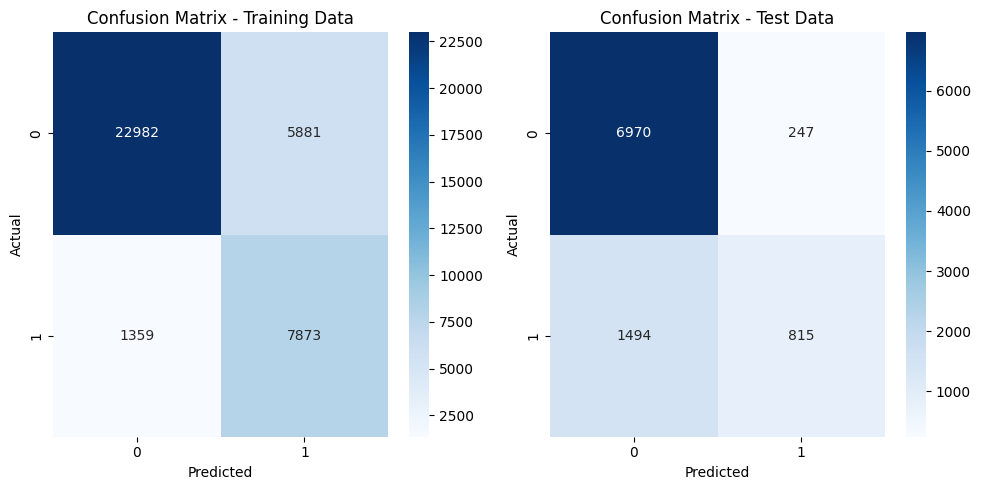

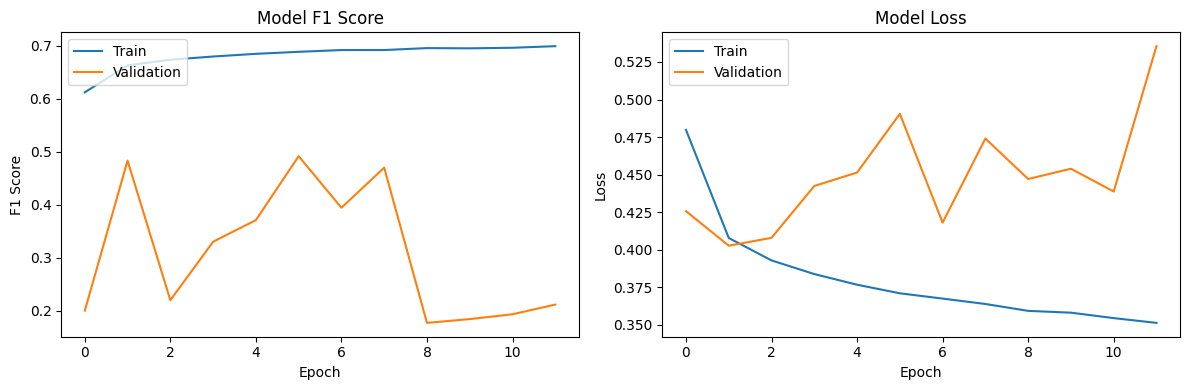

In [13]:
run_dnn(train_df_encoded, test_df_encoded)

# load one hot new

In [18]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
# from .customErrors import TestTrainDiffError

# def prepend_col_name(df, columns):
#     for col in columns:
#         df[col] = df[col].apply(lambda x: f"{col}_{x}")
#     return df

def onehot_new(xtrain, xtest, categorical_columns, verbose=False):
    # Copy data to avoid modifying originals
    xtrain_copy = xtrain.copy()
    xtest_copy = xtest.copy()

    ## Prepend column names to categorical values
    # xtrain_copy = prepend_col_name(xtrain_copy, categorical_columns)
    # xtest_copy = prepend_col_name(xtest_copy, categorical_columns)

    # Check for differences between train and test categories before encoding
    for col in categorical_columns:
        dif1 = set(xtest_copy[col].unique()) - set(xtrain_copy[col].unique())
        if dif1:
            error_message = f"""
            Differences found between xtest and xtrain in column: "{col}"
            Number of unique values in test (test - train): {len(dif1)}
            Unique values: {dif1}
            """
            raise TestTrainDiffError(error_message)

    # Apply OneHotEncoder to categorical columns
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(xtrain_copy[categorical_columns])

    # Transform both train and test sets
    xtrain_encoded = encoder.transform(xtrain_copy[categorical_columns])
    xtest_encoded = encoder.transform(xtest_copy[categorical_columns])

    # Create DataFrame for one-hot encoded columns
    encoded_columns = encoder.get_feature_names_out(categorical_columns)
    xtrain_onehot_df = pd.DataFrame(xtrain_encoded, columns=encoded_columns, index=xtrain_copy.index)
    xtest_onehot_df = pd.DataFrame(xtest_encoded, columns=encoded_columns, index=xtest_copy.index)

    # Concatenate numerical columns and one-hot encoded columns
    numerical_cols = list(set(xtrain.columns) - set(categorical_columns))
    xtrain_prep = pd.concat([xtrain[numerical_cols], xtrain_onehot_df], axis=1)
    xtest_prep = pd.concat([xtest[numerical_cols], xtest_onehot_df], axis=1)

    if verbose:
        print("xtrain_prep shape:", xtrain_prep.shape)
        print("xtest_prep shape:", xtest_prep.shape)

    return xtrain_prep, xtest_prep


In [19]:
train_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_train.csv")
test_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_test.csv")

categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']                    

train_df_encoded, test_df_encoded = onehot_new(train_df, test_df, categorical_vars, verbose=True)

xtrain_prep shape: (38095, 109)
xtest_prep shape: (9526, 109)


In [20]:
train_df_encoded

,fnlwgt,age,capital-loss,hours-per-week,capital-gain,education-num,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,193106,37,0,30,0,13,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,216636,56,1651,40,0,8,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,126977,53,0,35,0,9,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,205343,72,0,40,0,7,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,106705,46,0,38,0,14,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38090,37718,45,0,40,0,13,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38091,223400,58,0,20,0,13,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38092,229062,61,1887,40,0,10,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
38093,81965,38,0,40,0,11,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


d:\SummerResearch\summer_research\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Computed Class Weights: {0: 0.6599279354190486, 1: 2.0632040727902945}
Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - Precision: 0.4350 - Recall: 0.7649 - accuracy: 0.6978 - loss: 0.5445 - val_Precision: 0.5609 - val_Recall: 0.8172 - val_accuracy: 0.8007 - val_loss: 0.3849
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Precision: 0.5439 - Recall: 0.8587 - accuracy: 0.7922 - loss: 0.4118 - val_Precision: 0.5532 - val_Recall: 0.8359 - val_accuracy: 0.7966 - val_loss: 0.3848
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - Precision: 0.5513 - Recall: 0.8603 - accuracy: 0.7973 - loss: 0.3950 - val_Precision: 0.5700 - val_Recall: 0.8324 - val_accuracy: 0.8072 - val_loss: 0.3758
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - Precision: 0.5592 - Recall: 0.8663 - accuracy: 0.8030 - loss: 0.3863 - val_Precision: 0.5764 - val_Recall: 0.8281 - val_accuracy: 0.8108 - val_loss: 0.3682
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - Precision: 0.5621 - Recal

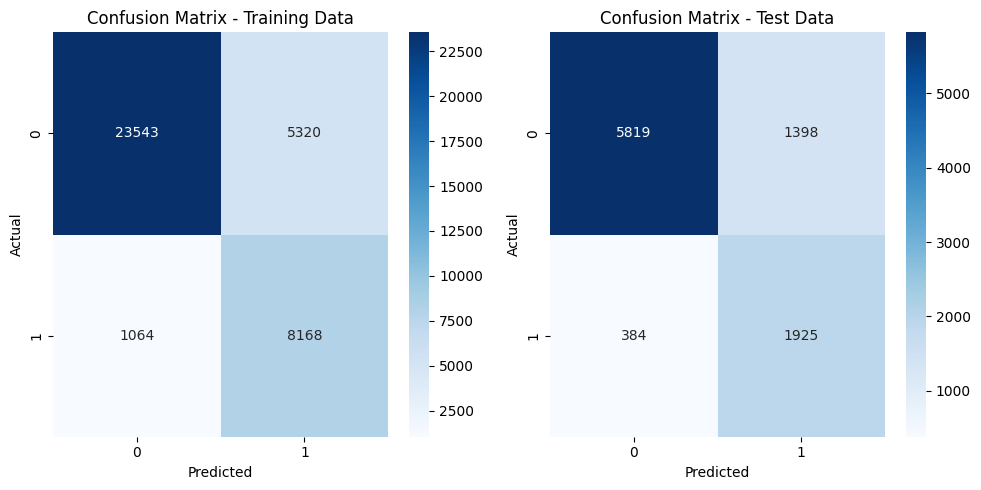

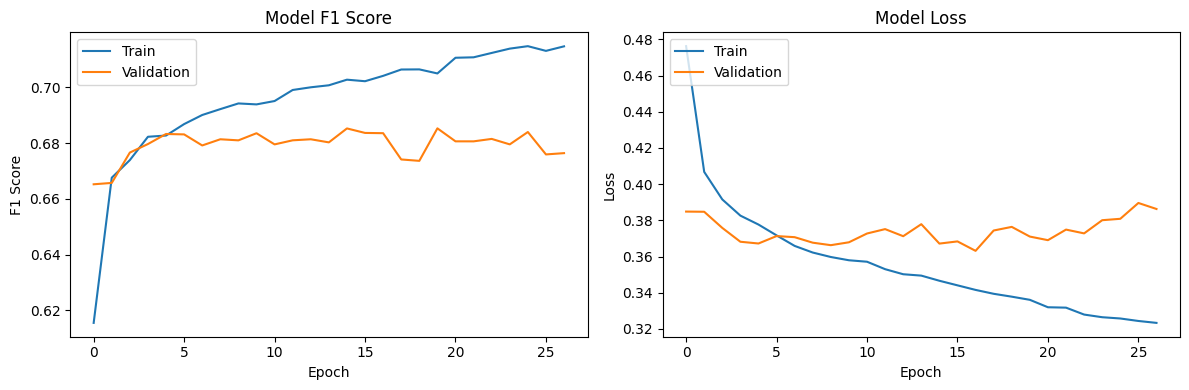

In [15]:
run_dnn(train_df_encoded, test_df_encoded)

## onehot from scratch

In [17]:
train_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_train.csv")
test_df = pd.read_csv("D:\\SummerResearch\data\\adult\\adult_test.csv")

import pandas as pd

# List of categorical variables
categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'native-country']

# One-hot encode categorical variables in the training set
X_train_encoded = pd.get_dummies(train_df, columns=categorical_vars)

# One-hot encode categorical variables in the test set
X_test_encoded = pd.get_dummies(test_df, columns=categorical_vars)

# Ensure that both training and test sets have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [ ]:
run_dnn(X_train_encoded, X_test_encoded)